In [1]:
%cd ..
import tensorboard as tb
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import os
import re
import torch
import torch.nn as nn
import models
import math
from matplotlib.ticker import FixedLocator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
log_dir = '/mnt/ssd_3/DDOPaI/runs/pruning/cifar10/swin'

/mnt/ssd_3/DDOPaI


In [2]:
class TensorBoardAnalyzer:
    def __init__(self, log_dir):
        self.log_dir = log_dir
        self.experiment_data = {"baseline": []}
        self.ratio_data = {}

    def extract_test_acc(self):
        """Extracts the final test_acc values from all relevant event files in the log directory."""
        for experiment_dir in os.listdir(self.log_dir):
            full_experiment_path = os.path.join(self.log_dir, experiment_dir)
            if os.path.isdir(full_experiment_path):
                if 'baseline' in experiment_dir:
                    self._process_baseline(full_experiment_path)
                elif 'swin' in experiment_dir:
                    self._process_swin(full_experiment_path, experiment_dir)
        return self.experiment_data

    def _process_baseline(self, path):
        summary_dir = os.path.join(path, 'summary')
        if os.path.exists(summary_dir):
            event_files = [os.path.join(summary_dir, f) for f in os.listdir(summary_dir) if f.startswith("events.out.tfevents")]
            if event_files:
                latest_event_file = max(event_files, key=os.path.getctime)
                event_acc = EventAccumulator(latest_event_file)
                event_acc.Reload()
                if 'iter_0/test/acc' in event_acc.Tags()['scalars']:
                    test_acc = event_acc.Scalars('iter_0/test/acc')[-1].value
                    self.experiment_data["baseline"].append(test_acc)

    def _process_swin(self, path, experiment_dir):
        base_name = re.findall(r'cifar10_swin_vit_(.*?)_prune_ratio', experiment_dir)
        if base_name:
            base_name = base_name[0]
            if base_name not in self.experiment_data:
                self.experiment_data[base_name] = {60: [], 80: [], 90: [], 95: [],98:[]}
                self.ratio_data[base_name] = {60: [], 80: [], 90: [], 95: [],98:[]}

            prune_ratio = re.findall(r'prune_ratio_(\d+)', experiment_dir)
            if prune_ratio:
                prune_ratio = int(prune_ratio[0])
                summary_dir = os.path.join(path, 'summary')
                if os.path.exists(summary_dir):
                    event_files = [os.path.join(summary_dir, f) for f in os.listdir(summary_dir) if f.startswith("events.out.tfevents")]
                    if event_files:
                        latest_event_file = max(event_files, key=os.path.getctime)
                        event_acc = EventAccumulator(latest_event_file)
                        event_acc.Reload()
                        if 'iter_0/test/acc' in event_acc.Tags()['scalars']:
                            test_acc = event_acc.Scalars('iter_0/test/acc')[-1].value
                            self.experiment_data[base_name][prune_ratio].append(test_acc)
                            self._extract_ratio(path, base_name, prune_ratio)

    def _extract_ratio(self, path, base_name, prune_ratio):
        checkpoint_dir = os.path.join(path, 'checkpoint')
        if os.path.exists(checkpoint_dir):
            checkpoint_files = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith("prune") and f.endswith(".pth.tar")]
            if checkpoint_files:
                latest_checkpoint_file = max(checkpoint_files, key=os.path.getctime)
                checkpoint = torch.load(latest_checkpoint_file)
                key_to_exclude = 'ratio'
                ratio = {k: v for k, v in checkpoint.get('ratio', None).items() if k != key_to_exclude}
                #ratio = checkpoint.get('ratio', None)
                if ratio is not None:
                    self.ratio_data[base_name][prune_ratio].append(ratio)
                del checkpoint
                torch.cuda.empty_cache()
    def process_ratio_data(self,ratio_data):
        processed_data = {}
        for method, prune_dict in ratio_data.items():
            processed_data[method] = {}
            for prune_ratio, value_list in prune_dict.items():
                processed_data[method][prune_ratio] = [list(inner_dict.values())[0] for inner_dict in value_list]
        return processed_data

analyzer = TensorBoardAnalyzer(log_dir)
data = analyzer.extract_test_acc()

ratio_data = analyzer.ratio_data

print(data)
print(ratio_data)

{'baseline': [84.22000122070312], 'SNIP': {60: [84.47000122070312, 84.13999938964844, 82.62999725341797], 80: [82.8499984741211, 83.41999816894531, 82.27999877929688], 90: [80.83000183105469, 78.58999633789062, 80.9000015258789], 95: [78.86000061035156, 77.83999633789062, 79.11000061035156], 98: []}, 'SNIP_DD': {60: [84.68000030517578, 84.3499984741211, 84.08000183105469], 80: [83.83000183105469, 82.26000213623047, 83.4000015258789], 90: [79.62999725341797, 81.47000122070312, 80.70999908447266], 95: [79.4000015258789, 79.63999938964844, 78.44999694824219], 98: []}, 'GraSP_SD': {60: [84.43000030517578, 82.86000061035156, 83.73999786376953], 80: [84.33000183105469, 83.62999725341797, 82.5], 90: [83.7300033569336, 83.5999984741211, 81.2699966430664], 95: [83.70999908447266, 80.41999816894531, 83.61000061035156], 98: [82.19000244140625]}, 'GraSP': {60: [84.01000213623047, 82.76000213623047, 84.38999938964844], 80: [82.91000366210938, 81.87000274658203, 82.9000015258789], 90: [81.5299987792

## FLOPs Computation
We now explain the computation of FLOPs in forwardand passes in models. We consider that one addition and one multiplicationeach counts as a FLOP. The FLOPs for the forward pass is 2 * n_in * n_out * d, where d is the density of this FC layer。For conv layer, the forward pass is  2 * H * W * C_in * C_out * K * K * d.

In [3]:
def compute_forward_flops(layer, density):
    
    if isinstance(layer, nn.Linear):
        n_in = layer.in_features
        n_out = layer.out_features
        if layer.bias is not None:
            forward_flops = 2 * n_in * n_out * density
        else:
            forward_flops = 2 * (n_in - 1) * n_out * density
        
    elif isinstance(layer, nn.Conv2d):
        C_in = layer.in_channels
        C_out = layer.out_channels
        K = layer.kernel_size[0]
        H, W = layer.output_shape[2:]
        forward_flops = 2 * H * W * C_in * C_out * K * K * density
        
    else:
        raise ValueError("Unsupported layer type. Only Linear and Conv2d layers are supported.")
    forward_flops = math.ceil(forward_flops)
    return forward_flops
def process_ratio_data(ratio_data):

    flops_data = {}
    
    for method, prune_dict in ratio_data.items():
        flops_data[method] = {}
        for prune_ratio, value_list in prune_dict.items():
            flops_data[method][prune_ratio] = []
            total_flops = 0
            for layer_dict in value_list:
                total_flops = 0
                for layer, sparsity in layer_dict.items():
                    flops = compute_forward_flops(layer, sparsity)
                    total_flops += flops

                flops_data[method][prune_ratio].append(total_flops)
            
            flops_data[method][prune_ratio]=np.average(flops_data[method][prune_ratio])   
    return flops_data
processed_flops_data = process_ratio_data(ratio_data)


/home/lab4y/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/lab4y/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
baseline=ratio_data['SNIP'][60][0]
total_flops = 0
for layer, sparsity in baseline.items():
    flops = compute_forward_flops(layer, 100)
    total_flops += flops
processed_flops_data['baseline']=total_flops

In [5]:
extracted_test_acc=data

flops_acc_data = {}

for method in processed_flops_data.keys():
    flops_acc_data[method]=[]
    if method=='baseline':
        flops_acc_data[method].append([processed_flops_data[method], extracted_test_acc[method]])
    else:
        for ratio in processed_flops_data[method].keys():
            flops = processed_flops_data[method][ratio]
            if method in extracted_test_acc and ratio in extracted_test_acc[method]:
                accs = extracted_test_acc[method][ratio]
                if len(accs)>0:
                    flops_acc_data[method].append([flops, accs])


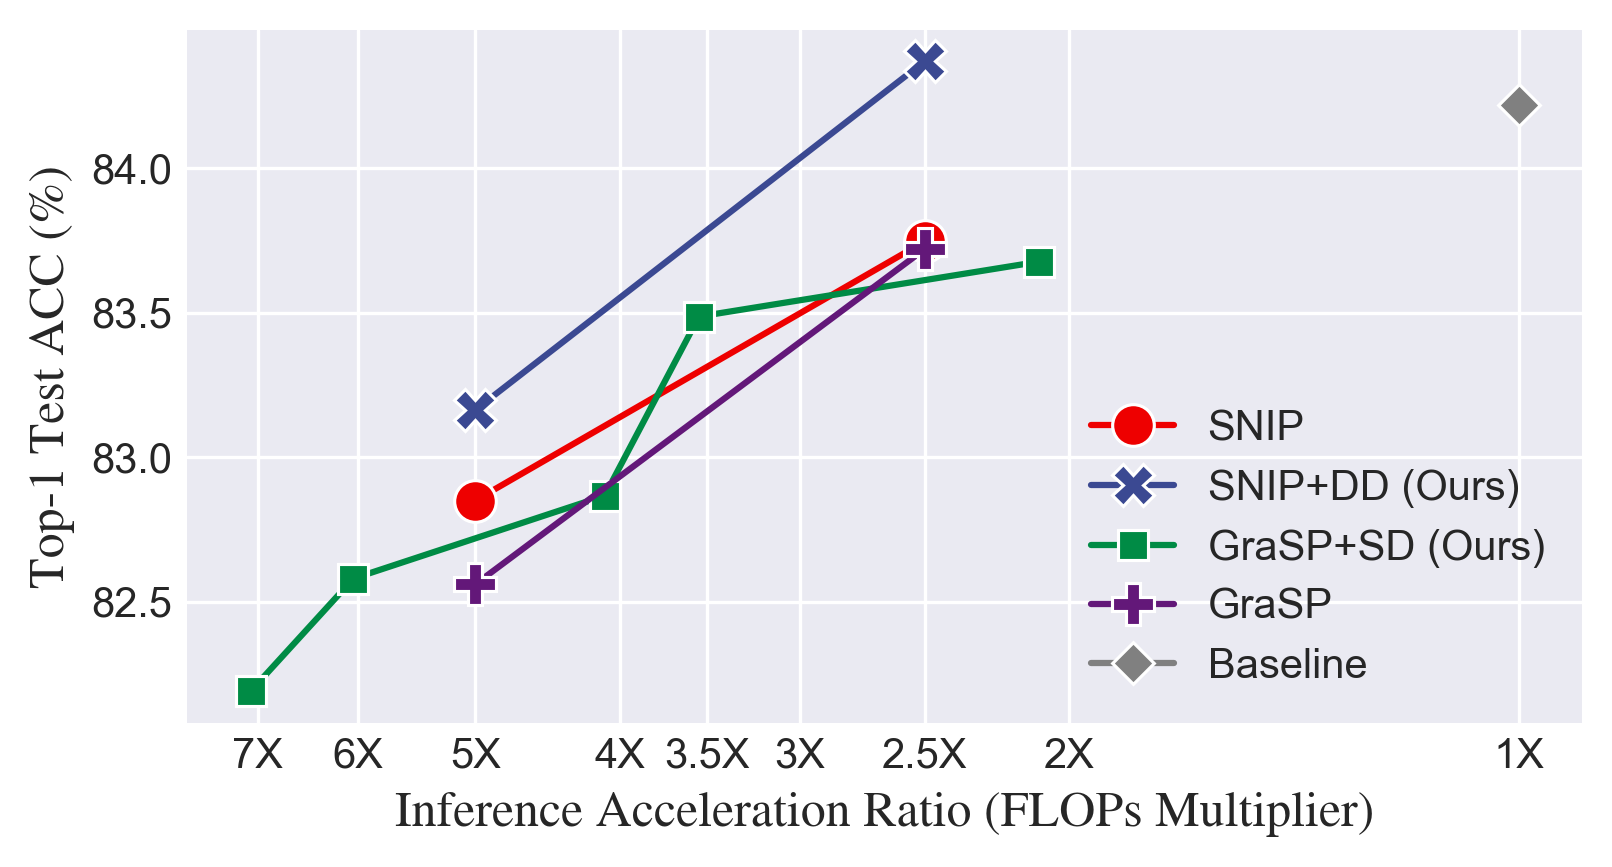

In [8]:
font1 = {
    'weight' : 'normal',
    'size'   : 10,
     "family":'Nimbus Roman'
    }
plt_data = []
new_method={
    'SNIP':'SNIP',
    'GraSP':'GraSP',
    'SNIP_DD':'SNIP+DD (Ours)',
    'GraSP_SD':'GraSP+SD (Ours)',
    'baseline':'Baseline'
}

method_colors = {
    'SNIP': '#EE0000',
    'SNIP+DD (Ours)': '#3B4992',
    'GraSP+SD (Ours)': '#008B45',
    'GraSP': '#631879',
    'Baseline': 'grey'
}
for method, values in flops_acc_data.items():
    for flops, accs in values:
        acc=np.average(accs)
        #for acc in accs:
        plt_data.append({'Method': new_method[method], 'FLOPs': flops, 'Top-1 Acc': acc})



df = pd.DataFrame(plt_data)    

baseline_flops = max(df['FLOPs'])
df['FLOPs_Multiplier'] = df['FLOPs'] / baseline_flops
baseline_acc = df[df['Method'] == 'Baseline']['Top-1 Acc'].mean()
threshold = 2.1
df_filtered = df[(df['Top-1 Acc'] >= baseline_acc - threshold) & (df['Top-1 Acc'] <= baseline_acc + threshold)]

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(6, 3),dpi=300)

ax=sns.lineplot(x='FLOPs_Multiplier', y='Top-1 Acc', hue='Method', data=df_filtered, markers=True, style='Method', dashes=False, palette=method_colors, markersize=10)


plt.xscale('log')
ax.xaxis.set_major_locator(FixedLocator([0.143, 0.167, 0.2, 0.25, 0.286, 0.33,0.4, 0.5, 1]))
plt.xticks([0.143, 0.167, 0.2, 0.25, 0.286, 0.33,0.4, 0.5, 1], ['7X', '6X', '5X', '4X', '3.5X', '3X','2.5X', '2X', '1X'])


ax.xaxis.set_minor_locator(FixedLocator([]))
plt.xlabel('Inference Acceleration Ratio (FLOPs Multiplier)', fontsize=12, weight='normal', family='Nimbus Roman')
plt.ylabel('Top-1 Test ACC (%)', fontsize=12, weight='normal', family='Nimbus Roman')


plt.legend()
plt.show()